# Visualizing the GAN results

Let's visualize some random results from the GAN. To do so we just need to load a generator model and feed it with random Gaussian noise of the approriate size

## Visualizing the results in a notebook

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os 

latent_dim = 100
model_path = './models/dcgan_dmlap'
def random_latent_vector(n=0):
    if n==0:
        return np.random.normal(size=latent_dim)
    return np.vstack([np.random.normal(size=latent_dim) for i in range(n)]) # np.random.normal(size=[n, latent_dim])

generator = keras.models.load_model(os.path.join(model_path, 'e30_generator.hd5'))

The following code will generate a specified number of images:

In [48]:
def generate_images(noise):
    generated_images = generator(noise, training=False).numpy()
    # Convert images to 0-1 range (sufficient to visualize here in notebook)
    generated_images = generated_images*0.5 + 0.5
    return generated_images

noise = random_latent_vector(20)
generated_images = generate_images(noise)

and then we view them organized as a grid

4


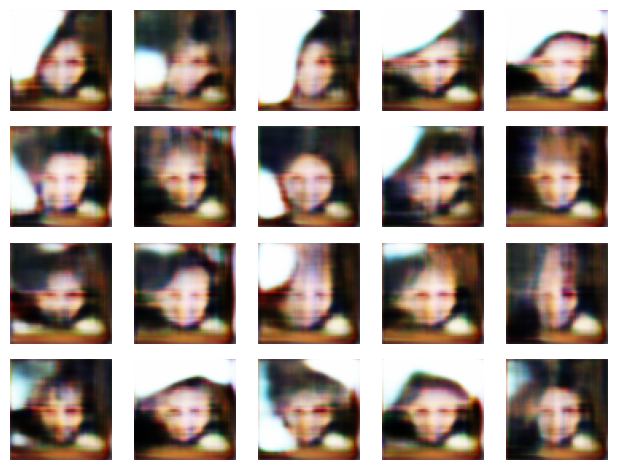

In [49]:

def show_image_grid(images, ncols, size=None, title=''):
    ''' Display multiple images in a grid'''
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    n = len(images)
    nrows = int(np.ceil(n/ncols))
    print(nrows)
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure()
    if title:
        plt.title(title)
    gs = GridSpec(nrows, ncols)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_image_grid(generated_images, 5)

## Interpolating in latent space

We can interpolate between a point in the "latent space" and another to produce a smooth transition between images generated by the GAN. To do so, it is recommended to use "spherical linear interpolation", 
as the multivariate Gaussian used by the GAN can be approximated by a hypersphere (a sphere in high dimensions). See [this](https://github.com/soumith/dcgan.torch/issues/14) and [this](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/) for technical details and to see where the interpolation code comes from.

In [45]:
from numpy import arccos, sin, clip, dot
from numpy.linalg import norm

def lerp(t, a, b):
    return a + t*(b - a)

def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1.0, 1.0))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

Now let's generate two random vectors and interpolate between them in 10 steps

1


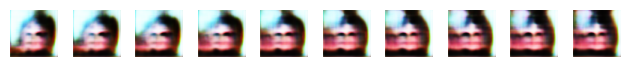

In [46]:
num_steps = 10
a = random_latent_vector()
b = random_latent_vector()
images = []
for t in np.linspace(0, 1, num_steps):
    noise = slerp(t, a, b)
    images.append(generate_images(np.expand_dims(noise, 0)))
images = np.vstack(images)
show_image_grid(images, num_steps)


## Interactive viewing

To interactively view the interpolation you can install [Py5Canvas](https://github.com/colormotor/py5canvas) (follow the instructions). Then run the `gan_visualizer.py` script provided in the `py5sketches` directory of this repository.